In [1]:
import pandas
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy

tfd = tfp.distributions

In [5]:
url = ('https://github.com/CSSEGISandData/COVID-19/raw'
       '/master/csse_covid_19_data/csse_covid_19_time_series/'
       'time_series_covid19_confirmed_global.csv')
raw_df = pandas.read_csv(url)

In [7]:
del raw_df['Lat']
del raw_df['Long']

In [12]:
df = raw_df.set_index(['Country/Region', 'Province/State']).transpose()

In [24]:
df = df.set_index(pandas.to_datetime(df.index))

In [26]:
data = pandas.DataFrame({c: df[c].sum(axis=1) for c in df.columns.get_level_values(0)})

<AxesSubplot:>

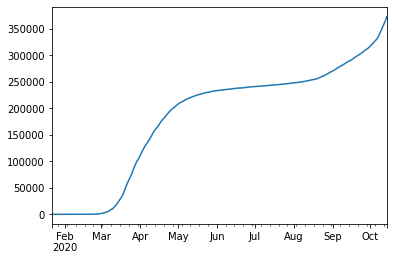

In [27]:
data['Italy'].plot()

# SIR

$$\frac{dI}{dt} = \beta \frac{SI}{N} - \gamma I$$

Here

$$R = \frac{\beta}{\gamma}$$

In [29]:
confirmed = data['Italy']

In [30]:
deltas = confirmed - confirmed.shift(1)

<AxesSubplot:>

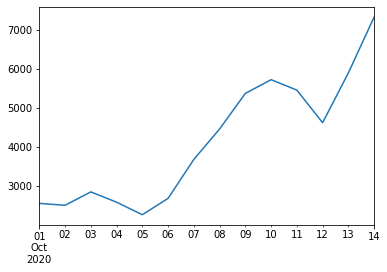

In [32]:
deltas['2020-10'].plot()

In [39]:
ks = deltas.rolling(7, win_type='gaussian').mean(std=3).dropna().round()

<AxesSubplot:>

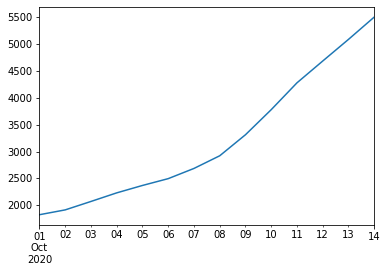

In [40]:
ks['2020-10'].plot()

# A simple model

In [41]:
Rs = tf.linspace(0.5, 2., 1000)

In [50]:
models = tfd.Poisson(rate=ks['2020-10-04']*tf.exp((Rs - 1)/5.2))

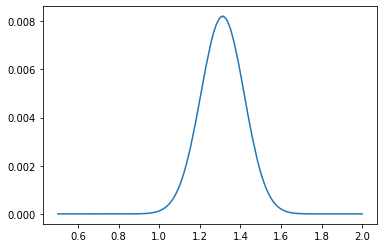

In [51]:
plt.plot(Rs, models.prob(ks['2020-10-05']))

In [46]:
ks['2020-10']

2020-10-01    1823.0
2020-10-02    1913.0
2020-10-03    2070.0
2020-10-04    2230.0
2020-10-05    2368.0
2020-10-06    2495.0
2020-10-07    2685.0
2020-10-08    2921.0
2020-10-09    3313.0
2020-10-10    3780.0
2020-10-11    4280.0
2020-10-12    4686.0
2020-10-13    5089.0
2020-10-14    5505.0
Name: Italy, dtype: float64

In [73]:
model = tfd.JointDistributionNamed({
    'R': tfd.Normal(1, 2), # prior on R
    'k': lambda R: tfd.Poisson(rate=ks['2020-10-04']*tf.exp((R - 1)/5.2))
})

In [74]:
model.resolve_graph()

(('R', ()), ('k', ('R',)))

In [75]:
model.sample()

{'R': <tf.Tensor: shape=(), dtype=float32, numpy=1.1588823>,
 'k': <tf.Tensor: shape=(), dtype=float32, numpy=2235.0>}

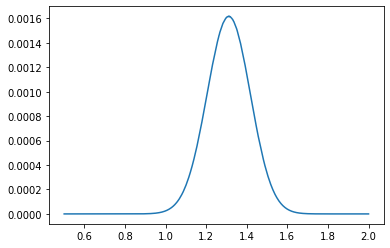

In [76]:
plt.plot(Rs, model.prob({'R': Rs, 'k': ks['2020-10-05']}))

# MAP

In [81]:
R = tf.Variable(2.)
losses = tfp.math.minimize(lambda: -model.log_prob({'R': R, 'k': ks['2020-10-05']}),
                           num_steps=500,
                           optimizer=tf.optimizers.Adam(learning_rate=0.01))

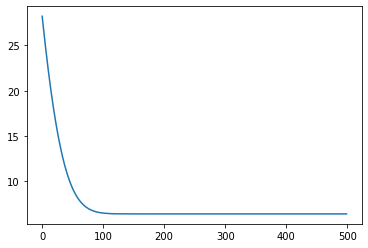

In [82]:
plt.plot(losses)

In [83]:
R

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.3113408>

# Multiple data points

In [84]:
tfd.Poisson([10, 20, 30]).sample()

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([14., 18., 31.], dtype=float32)>

In [85]:
ks['2020-10-04':'2020-10-06']

2020-10-04    2230.0
2020-10-05    2368.0
2020-10-06    2495.0
Name: Italy, dtype: float64

In [101]:
Tc = 5.2
ks_tf = tf.constant(ks['2020-10-04':'2020-10-06'], dtype=tf.float32)
model = tfd.JointDistributionNamed({
    'R': tfd.TruncatedNormal(loc=1, scale=3, low=0, high=10), # prior on R
    'k': lambda R: tfd.Independent(
        tfd.Poisson(rate=ks_tf*tf.exp((R[...,tf.newaxis] - 1)/5.2)), 1)
})

In [102]:
model.sample()

{'R': <tf.Tensor: shape=(), dtype=float32, numpy=1.1842774>,
 'k': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([2352., 2512., 2644.], dtype=float32)>}

In [103]:
model.prob(model.sample())

<tf.Tensor: shape=(), dtype=float32, numpy=1.3940931e-09>

In [104]:
model.prob({'R': [1.3, 2], 'k': ks['2020-10-05':'2020-10-07']})

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([7.2929609e-08, 7.4662397e-37], dtype=float32)>

In [105]:
def log_prob(R):
    return model.log_prob({'R': R, 'k': ks['2020-10-05':'2020-10-07']})

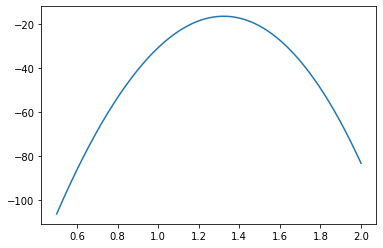

In [108]:
plt.plot(Rs, log_prob(Rs))

In [109]:
num_results = int(1e4)
num_burnin = int(1e4)
num_chains = 4

adaptive_hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=log_prob,
        num_leapfrog_steps=3,
        step_size=0.5),
    num_adaptation_steps=int(0.8*num_burnin)
)

@tf.function
def run_chain():
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin,
        current_state=numpy.ones((num_chains, 1), dtype=numpy.float32),
        kernel=adaptive_hmc
    )

In [110]:
samples, kernel_result = run_chain()

/Users/dirkhesse/.venv/venv/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [115]:
kernel_result.inner_results.is_accepted.numpy().sum(axis=0)/num_results

array([[0.9005],
       [0.8957],
       [0.8961],
       [0.8932]])

In [123]:
samples.shape

TensorShape([10000, 4, 1])

(array([  12.,   22.,   58.,  114.,  223.,  441.,  769., 1135., 1400.,
        1487., 1392., 1129.,  795.,  506.,  289.,  136.,   54.,   26.,
           5.,    7.]),
 array([1.1148363, 1.1364682, 1.1581001, 1.179732 , 1.2013638, 1.2229958,
        1.2446276, 1.2662594, 1.2878913, 1.3095232, 1.3311551, 1.3527869,
        1.3744189, 1.3960507, 1.4176825, 1.4393144, 1.4609463, 1.4825782,
        1.50421  , 1.525842 , 1.5474738], dtype=float32),
 <BarContainer object of 20 artists>)

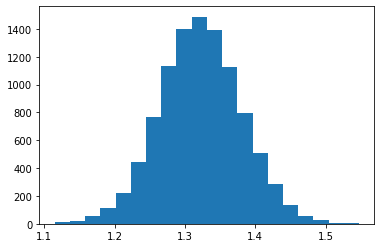

In [120]:
plt.hist(samples[:,0,0].numpy(), bins=20)

In [122]:
numpy.percentile(samples[:,0,0].numpy(), [2.5, 50, 97.5])

array([1.20682638, 1.32131296, 1.43654757])

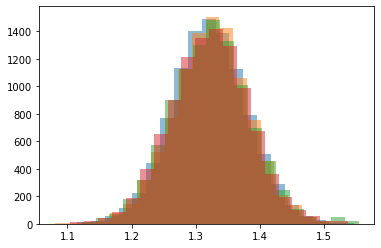

In [124]:
for i in range(num_chains):
    plt.hist(samples[:,i,0].numpy(), bins=20, alpha=0.5)

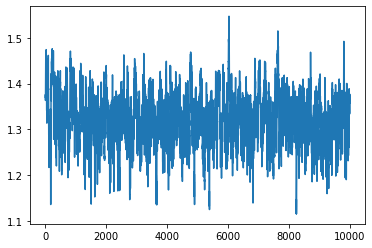

In [125]:
plt.plot(samples[:,0,0].numpy())

In [126]:
tfp.mcmc.potential_scale_reduction(samples)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.0002942], dtype=float32)>

# Posterior sampling

In [129]:
rates = tf.tensordot(ks_tf, tf.math.exp((samples[:,0,0] - 1)/Tc), axes=0)

In [130]:
posterior = tfd.Poisson(rates).sample()

In [131]:
posterior

<tf.Tensor: shape=(3, 10000), dtype=float32, numpy=
array([[2313., 2377., 2383., ..., 2349., 2391., 2373.],
       [2610., 2647., 2500., ..., 2544., 2512., 2555.],
       [2736., 2731., 2729., ..., 2694., 2648., 2593.]], dtype=float32)>

In [134]:
ks['2020-10-05':'2020-10-07']

2020-10-05    2368.0
2020-10-06    2495.0
2020-10-07    2685.0
Name: Italy, dtype: float64

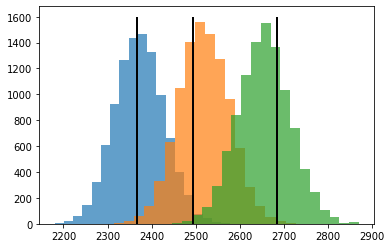

In [135]:
for i in range(len(ks_tf)):
    plt.hist(posterior[i].numpy(), bins=20, alpha=0.7)
    plt.vlines(ks['2020-10-05':'2020-10-07'], 0, 1600, colors='black')